In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-politics-2004-2019/IndiaVotes_PC__All_States_2009.csv
/kaggle/input/indian-politics-2004-2019/IndiaVotes_PC__All_States_2014.csv
/kaggle/input/indian-politics-2004-2019/2024.csv
/kaggle/input/indian-politics-2004-2019/2019.csv
/kaggle/input/indian-politics-2004-2019/cleaned.csv
/kaggle/input/indian-politics-2004-2019/2004.csv


# 2019

In [72]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns

In [38]:
df = pd.read_csv('/kaggle/input/indian-politics-2004-2019/cleaned.csv')

In [39]:
df.columns

Index(['Unnamed: 0', 'State_2004', 'Party_2004', 'Electors_2004', 'Votes_2004',
       'Turnout_2004', 'Margin_2004', 'Margin %_2004', 'State_2009',
       'Party_2009', 'Electors_2009', 'Votes_2009', 'Turnout_2009',
       'Margin_2009', 'Margin %_2009', 'State_2014', 'Party_2014',
       'Electors_2014', 'Votes_2014', 'Turnout_2014', 'Margin_2014',
       'Margin %_2014', 'State_2019', 'Party_2019', 'Electors_2019',
       'Votes_2019', 'Turnout_2019', 'Margin_2019', 'Margin %_2019',
       'State_2024', 'Party_2024', 'Electors_2024', 'Votes_2024',
       'Turnout_2024', 'Margin_2024', 'Margin %_2024'],
      dtype='object')

In [40]:
df.rename(columns={'Unnamed: 0': 'PC'}, inplace=True)

In [41]:
df.head()

,PC,State_2004,Party_2004,Electors_2004,Votes_2004,Turnout_2004,Margin_2004,Margin %_2004,State_2009,Party_2009,...,Turnout_2019,Margin_2019,Margin %_2019,State_2024,Party_2024,Electors_2024,Votes_2024,Turnout_2024,Margin_2024,Margin %_2024
0,Adilabad,0,0,1140834.0,830601.0,72.8,40974.0,4.9,0,28,...,77.9,58560.0,5.5,31,2,1650175.0,1235597.0,74.9,90652.0,7.3
1,Agra,1,1,1430713.0,642675.0,44.9,57342.0,8.9,1,2,...,61.7,211546.0,18.5,1,2,2072685.0,1123779.0,54.2,271294.0,24.1
2,Ajmer,2,2,1203803.0,529138.0,44.0,127976.0,24.2,2,4,...,69.0,416424.0,33.0,2,2,1995699.0,1201179.0,60.2,329991.0,27.5
3,Akbarpur,1,3,1446088.0,741543.0,51.3,58269.0,7.9,1,4,...,60.3,275142.0,26.8,1,2,1869167.0,1086953.0,58.2,44345.0,4.1
4,Akola,3,2,1271055.0,734524.0,57.8,106371.0,14.5,3,2,...,64.2,275596.0,24.6,3,2,1890814.0,1173072.0,62.0,40626.0,3.5


In [42]:
df.shape

(381, 36)

In [43]:
for column in df.columns:
    print(f'{column} : {df[column].dtype}')

PC : object
State_2004 : int64
Party_2004 : int64
Electors_2004 : float64
Votes_2004 : float64
Turnout_2004 : float64
Margin_2004 : float64
Margin %_2004 : float64
State_2009 : int64
Party_2009 : int64
Electors_2009 : float64
Votes_2009 : float64
Turnout_2009 : float64
Margin_2009 : float64
Margin %_2009 : float64
State_2014 : int64
Party_2014 : int64
Electors_2014 : float64
Votes_2014 : float64
Turnout_2014 : float64
Margin_2014 : float64
Margin %_2014 : float64
State_2019 : int64
Party_2019 : int64
Electors_2019 : float64
Votes_2019 : float64
Turnout_2019 : float64
Margin_2019 : float64
Margin %_2019 : float64
State_2024 : int64
Party_2024 : int64
Electors_2024 : float64
Votes_2024 : float64
Turnout_2024 : float64
Margin_2024 : float64
Margin %_2024 : float64


In [55]:
max(df['Party_2019'].unique())

57

In [56]:
min(df['Party_2019'].unique())

0

In [57]:
df['Party_2019'].nunique()

32

In [59]:
# how the heck are there 32 unique parties but max is 57? 
# Step 1: Get the unique classes and sort them
original_classes = sorted(df['Party_2019'].unique())

# Step 2: Create a mapping from original classes to new labels starting from 0
label_mapping = {original_classes[i]: i for i in range(len(original_classes))}

# Step 3: Map the original labels in the DataFrame to the new labels
df['Party_2019_mapped'] = df['Party_2019'].map(label_mapping)

# Display the mapping and the new class labels
print("Original classes:", original_classes)
print("Label mapping:", label_mapping)
print("New class labels:", df['Party_2019_mapped'].unique())

Original classes: [0, 1, 2, 3, 4, 6, 7, 8, 12, 15, 17, 18, 19, 21, 22, 23, 26, 32, 34, 39, 41, 42, 46, 47, 49, 51, 52, 53, 54, 55, 56, 57]
Label mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5, 7: 6, 8: 7, 12: 8, 15: 9, 17: 10, 18: 11, 19: 12, 21: 13, 22: 14, 23: 15, 26: 16, 32: 17, 34: 18, 39: 19, 41: 20, 42: 21, 46: 22, 47: 23, 49: 24, 51: 25, 52: 26, 53: 27, 54: 28, 55: 29, 56: 30, 57: 31}
New class labels: [ 2  6  4  3 12 17  8  1  7  9  5 18 25 20 26 15 11 27  0 19 28 16 29 10
 30 22 23 13 21 31 24 14]


In [60]:
features = [
    'State_2004', 'Electors_2004', 'Votes_2004', 'Turnout_2004', 'Margin_2004', 'Margin %_2004',
    'State_2009', 'Electors_2009', 'Votes_2009', 'Turnout_2009', 'Margin_2009', 'Margin %_2009',
    'State_2014', 'Electors_2014', 'Votes_2014', 'Turnout_2014', 'Margin_2014', 'Margin %_2014'
]
target = 'Party_2019_mapped'

In [61]:
X = df[features]
y = df[target]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

In [65]:
params = {
    'objective': 'multi:softprob',  # Multiclass classification
    'num_class': len(df[target].unique()),  # Number of classes
    'max_depth': 6,                  # Depth of the trees
    'eta': 0.3,                      # Learning rate
    'eval_metric': 'mlogloss'        # Metric to evaluate during training
}

In [66]:
xgb_model = xgb.train(
    params,
    train_data,
    num_boost_round=100,             # Number of boosting iterations
    evals=[(test_data, "Test")],     # For validation
    early_stopping_rounds=10         # Stop if no improvement
)

[0]	Test-mlogloss:1.71286
[1]	Test-mlogloss:1.51694
[2]	Test-mlogloss:1.36214
[3]	Test-mlogloss:1.28646
[4]	Test-mlogloss:1.23416
[5]	Test-mlogloss:1.19847
[6]	Test-mlogloss:1.17819
[7]	Test-mlogloss:1.17075
[8]	Test-mlogloss:1.16561
[9]	Test-mlogloss:1.16027
[10]	Test-mlogloss:1.16178
[11]	Test-mlogloss:1.16500
[12]	Test-mlogloss:1.16987
[13]	Test-mlogloss:1.17471
[14]	Test-mlogloss:1.17803
[15]	Test-mlogloss:1.17849
[16]	Test-mlogloss:1.17783
[17]	Test-mlogloss:1.17837
[18]	Test-mlogloss:1.18565
[19]	Test-mlogloss:1.18779


In [75]:
# Predict probabilities
y_pred_prob = xgb_model.predict(test_data)

# Convert probabilities to predicted classes
y_pred = [list(prob).index(max(prob)) for prob in y_pred_prob]

party_seat_counts = pd.Series(y_pred).value_counts().sort_index()

print("\nTotal predicted number of seats by each party:")
for party, seats in party_seat_counts.items():
    print(f"Party {party}: {seats} seats")

print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Total predicted number of seats by each party:
Party 0: 2 seats
Party 2: 59 seats
Party 4: 7 seats
Party 6: 1 seats
Party 8: 3 seats
Party 17: 4 seats
Party 25: 1 seats
Model Accuracy: 0.7012987012987013

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.80      0.90      0.85        52
           3       0.00      0.00      0.00         2
           4       0.14      0.25      0.18         4
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.67      1.00      0.80         2
           9       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          17       1.00      1.00      1.00         4
          23 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


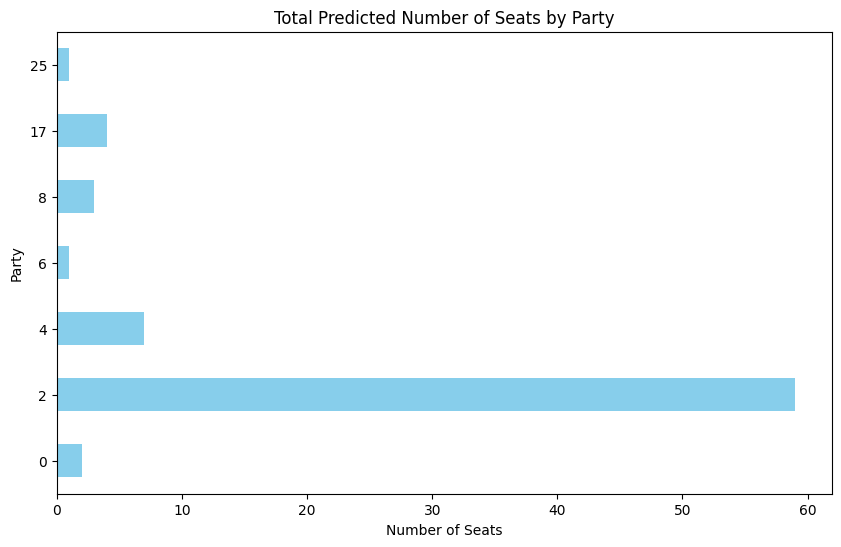

In [76]:
plt.figure(figsize=(10, 6))
party_seat_counts.plot(kind='barh', color='skyblue')

plt.xlabel('Number of Seats')
plt.ylabel('Party')
plt.title('Total Predicted Number of Seats by Party')

plt.show()

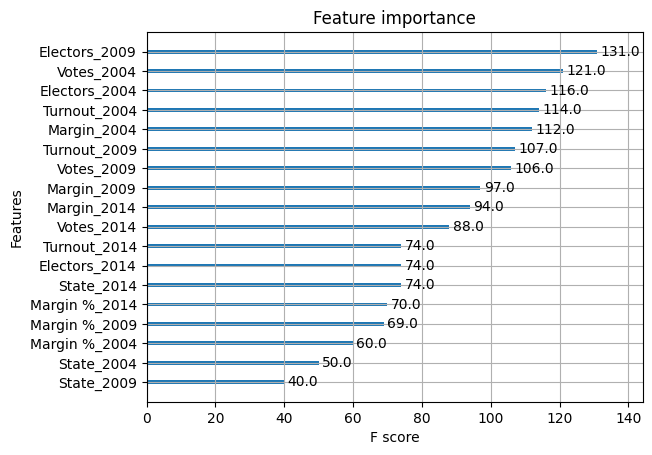

In [68]:
xgb.plot_importance(xgb_model)
import matplotlib.pyplot as plt
plt.show()

# 2024

In [77]:
original_classes_2024 = sorted(df['Party_2024'].unique())

label_mapping_2024 = {original_classes_2024[i]: i for i in range(len(original_classes_2024))}

df['Party_2024_mapped'] = df['Party_2024'].map(label_mapping_2024)

print("Original classes for 2024:", original_classes_2024)
print("Label mapping for 2024:", label_mapping_2024)
print("New class labels for 2024:", df['Party_2024_mapped'].unique())

Original classes for 2024: [1, 2, 4, 6, 7, 8, 11, 13, 17, 18, 21, 22, 25, 29, 32, 34, 42, 47, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
Label mapping for 2024: {1: 0, 2: 1, 4: 2, 6: 3, 7: 4, 8: 5, 11: 6, 13: 7, 17: 8, 18: 9, 21: 10, 22: 11, 25: 12, 29: 13, 32: 14, 34: 15, 42: 16, 47: 17, 51: 18, 53: 19, 54: 20, 56: 21, 57: 22, 58: 23, 59: 24, 60: 25, 61: 26, 62: 27, 63: 28, 64: 29, 65: 30, 66: 31, 67: 32, 68: 33, 69: 34}
New class labels for 2024: [ 1  2  0 23 14 24  7  5 25 26 27  3  6 15 18 10  4 28 29 30 31 16 19 32
  9 12 20 33  8 21 17 34 22 11 13]


In [78]:
features_2024 = [
    'State_2004', 'Electors_2004', 'Votes_2004', 'Turnout_2004', 'Margin_2004', 'Margin %_2004',
    'State_2009', 'Electors_2009', 'Votes_2009', 'Turnout_2009', 'Margin_2009', 'Margin %_2009',
    'State_2014', 'Electors_2014', 'Votes_2014', 'Turnout_2014', 'Margin_2014', 'Margin %_2014',
    'State_2019', 'Electors_2019', 'Votes_2019', 'Turnout_2019', 'Margin_2019', 'Margin %_2019'
]

target_2024 = 'Party_2024_mapped'

X = df[features_2024]
y = df[target_2024]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

In [81]:
params = {
    'objective': 'multi:softprob',  # Multi-class classification
    'num_class': len(df[target_2024].unique()),  # Number of classes
    'max_depth': 6,                  # Depth of the trees
    'eta': 0.3,                      # Learning rate
    'eval_metric': 'mlogloss'        # Metric to evaluate during training
}

In [82]:
xgb_model = xgb.train(
    params,
    train_data,
    num_boost_round=100,             # Number of boosting iterations
    evals=[(test_data, "Test")],     # For validation
    early_stopping_rounds=10         # Stop if no improvement
)

[0]	Test-mlogloss:2.25672
[1]	Test-mlogloss:2.08778
[2]	Test-mlogloss:1.95548
[3]	Test-mlogloss:1.87372
[4]	Test-mlogloss:1.81620
[5]	Test-mlogloss:1.79470
[6]	Test-mlogloss:1.78698
[7]	Test-mlogloss:1.78274
[8]	Test-mlogloss:1.79583
[9]	Test-mlogloss:1.81164
[10]	Test-mlogloss:1.82221
[11]	Test-mlogloss:1.82860
[12]	Test-mlogloss:1.83076
[13]	Test-mlogloss:1.84301
[14]	Test-mlogloss:1.85936
[15]	Test-mlogloss:1.88159
[16]	Test-mlogloss:1.89579


In [83]:
y_pred_prob = xgb_model.predict(test_data)

y_pred = [list(prob).index(max(prob)) for prob in y_pred_prob]

party_seat_counts_2024 = pd.Series(y_pred).value_counts().sort_index()

print("\nTotal predicted number of seats by each party in 2024:")
for party, seats in party_seat_counts_2024.items():
    print(f"Party {party}: {seats} seats")

print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report for 2024:\n", classification_report(y_test, y_pred))


Total predicted number of seats by each party in 2024:
Party 0: 8 seats
Party 1: 47 seats
Party 2: 15 seats
Party 3: 1 seats
Party 14: 5 seats
Party 31: 1 seats
Model Accuracy: 0.5454545454545454

Classification Report for 2024:
               precision    recall  f1-score   support

           0       0.25      0.67      0.36         3
           1       0.66      0.74      0.70        42
           2       0.27      0.27      0.27        15
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          14       1.00      1.00      1.00         5
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          23       0.00      0.00      0.00         2
          26       0.00      0.00      0.00         1
          31

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

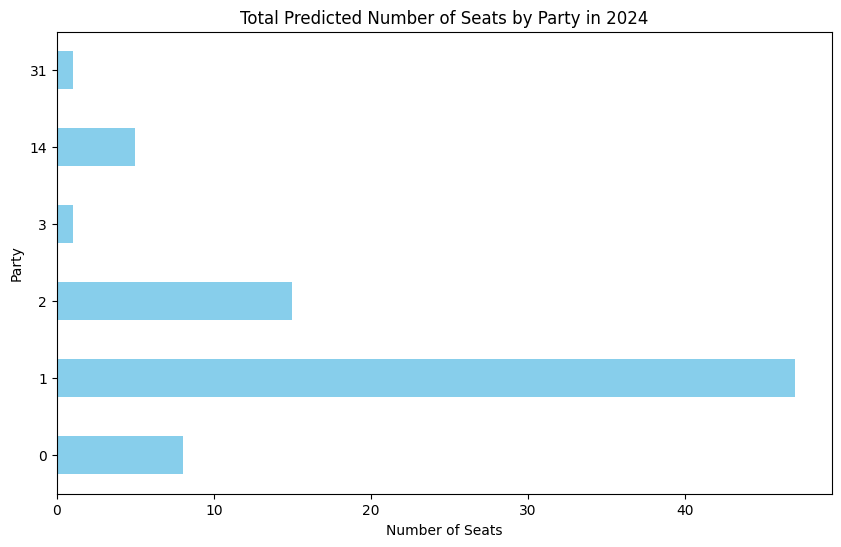

In [84]:
plt.figure(figsize=(10, 6))
party_seat_counts_2024.plot(kind='barh', color='skyblue')

plt.xlabel('Number of Seats')
plt.ylabel('Party')
plt.title('Total Predicted Number of Seats by Party in 2024')

plt.show()

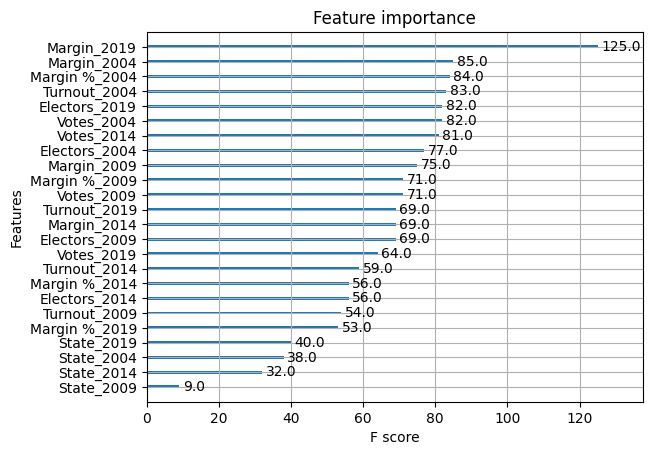

In [85]:
xgb.plot_importance(xgb_model)
plt.show()